In [8]:
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
from common import fetch_data, get_dual_backtest_result, get_hodl_result, max_drawdown, get_cache_path, save_cache_data, load_cache_data

In [9]:
# Input
exchanges_markets = [
    {
        "binance": "BTCUSDT",
        "bitmex": "XBTUSD",
        "apollox": "BTCUSDT",
        "drift": "BTC-PERP"
    },
    {
        "binance": "ETHUSDT",
        "bitmex": "ETHUSD",
        "apollox": "ETHUSDT",
        "drift": "ETH-PERP"
    },
    {
        "binance": "SOLUSDT",
        "bitmex": "SOLUSD",
        "apollox": "SOLUSDT",
        "drift": "SOL-PERP"
    },
    {
        "binance": "XRPUSDT",
        "bitmex": "XRPUSD",
        "apollox": "XRPUSDT",
        "drift": "XRP-PERP"
    },
    {
        "binance": "BNBUSDT",
        "bitmex": "BNBUSD",
        "apollox": "BNBUSDT",
        "drift": "BNB-PERP"
    },
]

hedge_map = {
    "binance": "bitmex",
    "bitmex": "binance",
    "apollox": "binance",
    "drift": "binance"
}

funding_freq_map = {
    "BTCUSDT": 8,
    "XBTUSD": 12,
    "BTCUSDT": 8,
    "BTC-PERP": 1,
    "ETHUSDT": 8,
    "ETHUSD": 8,
    "ETHUSDT": 8,
    "ETH-PERP": 1,
    "SOLUSDT": 8,
    "SOLUSD": 8,
    "SOLUSDT": 8,
    "SOL-PERP": 1,
    "XRPUSDT": 8,
    "XRPUSD": 8,
    "XRPUSDT": 8,
    "XRP-PERP": 1,
    "BNBUSDT": 8,
    "BNBUSD": 8,
    "BNBUSDT": 8,
    "BNB-PERP": 1,
}

In [10]:
# Compute all combinations of funding rate PNL

# Initial variables
min_time = datetime.fromisoformat('2023-05-01').timestamp()
max_time = datetime.fromisoformat('2023-12-31').timestamp()

data_df_map = {}
results = {}

leverages = [1, 3, 5, 7]

# Read data from file
for exchanges_market in exchanges_markets:
    for exchange, market in exchanges_market.items():
        data_df = load_cache_data(exchange, market)
        
        if exchange not in data_df_map:
            data_df_map[exchange] = {}
        data_df_map[exchange][market] = data_df

# calculate min max time
for exchanges_market in exchanges_markets:
    for exchange, market in exchanges_market.items():
        data_df = data_df_map[exchange][market]
        min_time = max(min_time, data_df["timestamp"].min())
        max_time = min(max_time, data_df["timestamp"].max())

# Calculate funding rate backtest result
for exchanges_market in exchanges_markets:
    for exchange, market in exchanges_market.items():
        short_df = data_df_map[exchange][market]
        short_df['datetime'] = short_df['datetime'].apply(lambda x: pd.to_datetime(x))
        short_df = short_df[
            (short_df["timestamp"] >= min_time) & (short_df["timestamp"] <= max_time)
        ]
        short_df = short_df.sort_values(by='datetime', ascending=True)
        short_df = short_df.reset_index(drop=True)
        
        long_exchange = hedge_map[exchange]
        long_market = exchanges_market[long_exchange]
        long_df = data_df_map[long_exchange][long_market]
        long_df['datetime'] = long_df['datetime'].apply(lambda x: pd.to_datetime(x))
        long_df = long_df[
            (long_df["timestamp"] >= min_time) & (long_df["timestamp"] <= max_time)
        ]
        long_df = long_df.sort_values(by='datetime', ascending=True)
        long_df = long_df.reset_index(drop=True)

        if exchange not in results:
            results[exchange] = {}
        if market not in results[exchange]:
            results[exchange][market] = {}

        for leverage in leverages:
            (result_df, _, _) = get_dual_backtest_result(long_df, short_df, funding_freq_map[long_market], funding_freq_map[market], leverage)
            results[exchange][market][leverage] = result_df

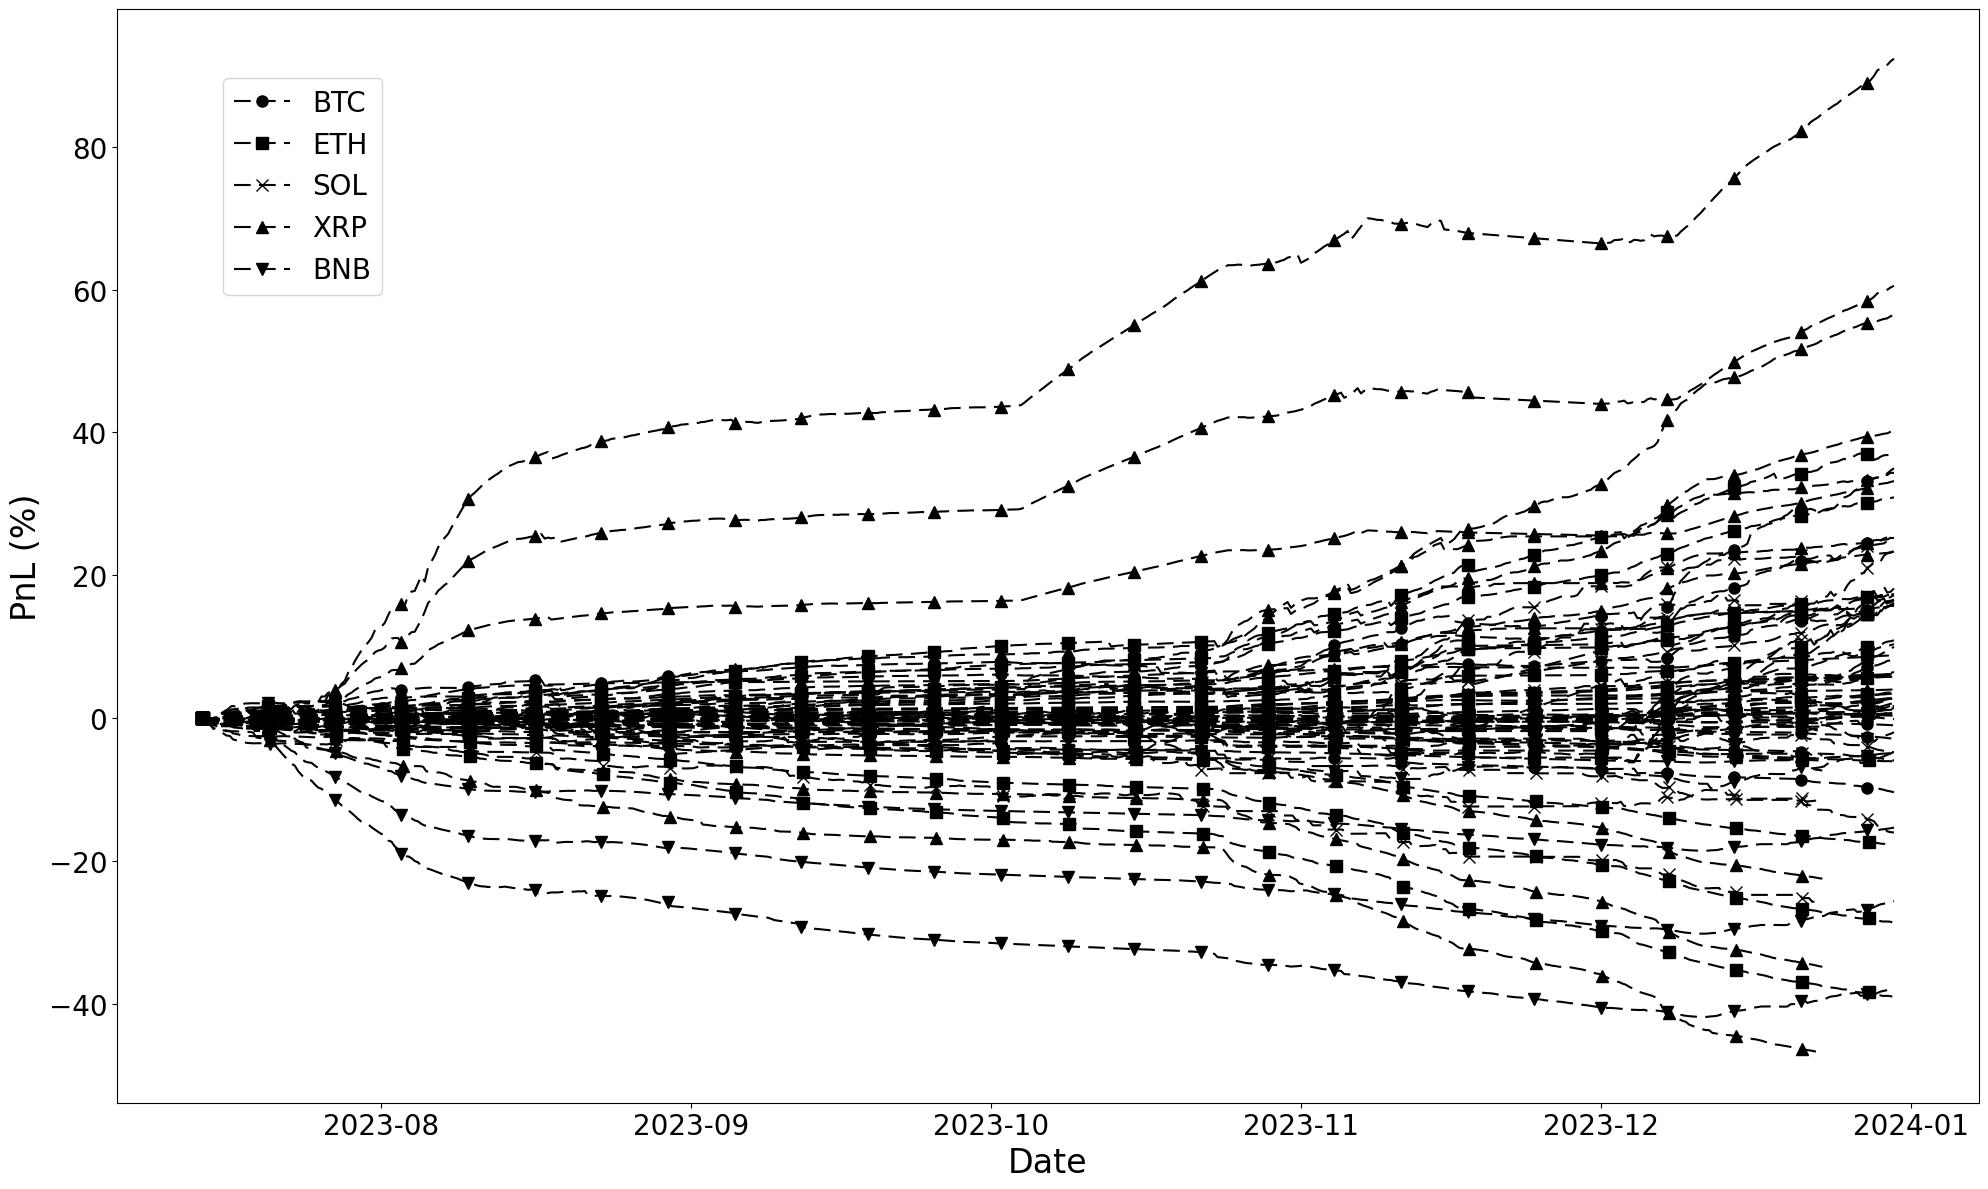

In [19]:
# Plot all combinations of funding rate arb PNL

line_styles = {
    "BTCUSDT": "--",
    "XBTUSD": "--",
    "BTCUSDT": "--",
    "BTC-PERP": "--",
    "ETHUSDT": ":",
    "ETHUSD": ":",
    "ETHUSDT": ":",
    "ETH-PERP": ":",
    "SOLUSDT": "--",
    "SOLUSD": "--",
    "SOLUSDT": "--",
    "SOL-PERP": "--",
    "XRPUSDT": "-.",
    "XRPUSD": "-.",
    "XRPUSDT": "-.",
    "XRP-PERP": "-.",
    "BNBUSDT": "-.",
    "BNBUSD": "-.",
    "BNBUSDT": "-.",
    "BNB-PERP": "-."
}

market_map = {
    "BTCUSDT": "BTC",
    "XBTUSD": "BTC",
    "BTCUSDT": "BTC",
    "BTC-PERP": "BTC",
    "ETHUSDT": "ETH",
    "ETHUSD": "ETH",
    "ETHUSDT": "ETH",
    "ETH-PERP": "ETH",
    "SOLUSDT": "SOL",
    "SOLUSD": "SOL",
    "SOLUSDT": "SOL",
    "SOL-PERP": "SOL",
    "XRPUSDT": "XRP",
    "XRPUSD": "XRP",
    "XRPUSDT": "XRP",
    "XRP-PERP": "XRP",
    "BNBUSDT": "BNB",
    "BNBUSD": "BNB",
    "BNBUSDT": "BNB",
    "BNB-PERP": "BNB"
}


markers = {"BTC": "o", "ETH": "s", "SOL": "x", "XRP": "^", "BNB": "v"}
mark_every = {"binance": 20, "bitmex": 20, "apollox": 20, "drift": 20}

fig, ax = plt.subplots(figsize=(20, 12))

# Plot funding arb result
for exchanges_market in exchanges_markets:
    for exchange, market in exchanges_market.items():
        for leverage in leverages:
            result_df = results[exchange][market][leverage]
            line,  = ax.plot(
                result_df["datetime"],
                result_df["total_pnl"] * 100,
                label=market_map[market],
                color="black",
                ms=8,
                marker=markers[market_map[market]],
                markevery=mark_every[exchange],
                # line_styles="--",
                # dash_styles=[[2, 8]]
                linestyle="--",
            )
            line.set_dashes([8, 4])

# Chart settings
plt.xlabel("Date", fontsize=24)
plt.ylabel("PnL (%)", fontsize=24)

lines, labels = ax.get_legend_handles_labels()
unique = dict(zip(labels, lines))
unique_labels = list(unique.keys())
unique_lines = list(unique.values())
ax.legend(unique_lines, unique_labels, loc="upper right", bbox_to_anchor=(0.15, 0.95), fontsize=20)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# Ensure a tight layout to avoid label/legend clipping
plt.tight_layout()

plt.savefig('./images/all_combinations.png', format='png', dpi=300, bbox_inches='tight')

plt.show()